# AI in Histopathology

Authors: Dr. Ali Bashashati, Faeze Keshavarz, and Amirali Darbandsari

**Note:** Only run the two cells below if you are running the code in Google Colab.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd gdrive/MyDrive/Colab\ Notebooks

## Introduction

Deep learning is a subfield of machine learning that uses artificial neural networks to learn from data, allowing machines to make accurate predictions and decisions. Deep learning has become increasingly popular in recent years, and has been successfully applied to a wide range of applications, including image recognition, natural language processing, and speech recognition.

In this notebook, we will explore the use of deep learning for analyzing histopathology data. Histopathology is the examination of tissues under a microscope, and is commonly used for diagnosing diseases such as cancer. With the advent of digital pathology, it has become possible to analyze histopathology images using computer algorithms, which can potentially improve accuracy and efficiency in diagnosing diseases.

We will provide code for building and training a convolutional neural network (CNN) for classifying histopathology images as either Normal or tumour. The code will be written in Python and will use the PyTorch framework. We will also provide sample data for you to use in the experiments.

It is important to note that the goal of this notebook is to provide an educational resource for understanding how deep learning can be applied to histopathology data. Therefore, we encourage you to experiment with the code and try different configurations to see how the model performs under different conditions. Throughout the notebook, we will provide guidance on how to modify the code and adjust hyperparameters to optimize the model's performance.

## Datasets

One of the most important aspects of deep learning is the quality and quantity of the data used to train and evaluate the models. In order to build an accurate and robust deep learning model, we need to have a large and diverse dataset that captures the variability and complexity of the problem at hand.

In this notebook, we will be using a dataset of histopathology images to train and evaluate our image classifier. The dataset consists of images of endometrial cancer tissue samples, with each image labeled as either Normal or Tumour based on a pathologist's diagnosis. The dataset is a crucial component of our deep learning project, as it provides the necessary information for the model to learn the distinguishing features of Normal and Tumour endometrial cancer tissue.

We have provided three datasets in this notebook: one for training the model, and two for evaluating the model's performance. 
1. The training dataset contains a total of 450 images, with 225 images labeled as Normal and 225 images labeled as Tumour. 
2. The first test dataset contains 50 images, with 25 images labeled as Normal and 25 images labeled as Tumour. 
3. The second test dataset contains 40 images, with 20 images labeled as Normal and 20 images labeled as Tumour. 

Both test datasets are labeled and can be used to evaluate the performance of the model on unseen data.

Below, we visualize sample images from our training dataset (the right and left images display the Normal and Tumour patches, respectively).

<table><tr>
<td> <img src="Images/Train/Normal/79872_21504.png" width="256"/> </td>
<td> <img src="Images/Train/Tumor/75776_49152.png" width="256"/> </td>
</tr></table>

## Data Preprocessing

Factors such as image orientation, light intensity, or image size should not affect the model training. So, some preprocessing steps are needed to provide variants of the histopathological images to the algorithm during the training phase.

You can try the code blocks below to get yourself familiar with some preprocessing steps.

In [1]:
# Load the required libraries for the notebook
import torch
import torchvision
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.utils.data as data
import torchvision.datasets as datasets
from sklearn.metrics import accuracy_score, confusion_matrix
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# For reproducibility, add seed:
torch.manual_seed(123)

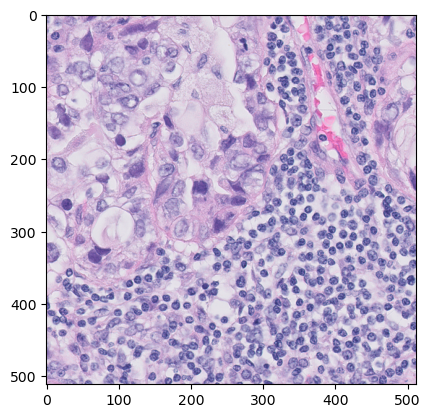

In [3]:
# An example of an origianl tumour image
tumour_image = torchvision.io.read_image(path='Images/Train/Tumor/74752_65536.png')
plt.imshow(tumour_image.permute(1,2,0))

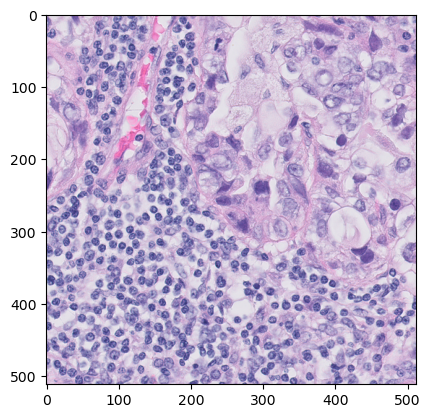

In [4]:
# Flip the image horizontally
hflipper = transforms.RandomHorizontalFlip(p=0.99)
h_transformed_tumour_img = hflipper(tumour_image)
plt.imshow(h_transformed_tumour_img.permute(1,2,0))

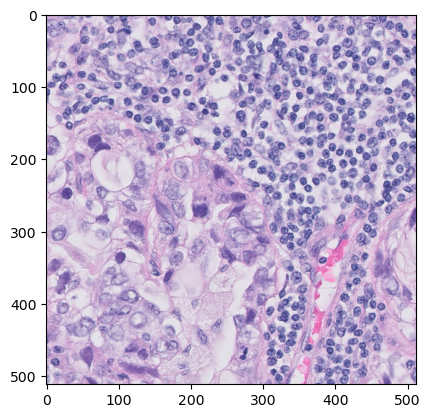

In [5]:
# Flip the image vertically
vflipper = transforms.RandomVerticalFlip(p=0.99)
v_transformed_tumour_img = vflipper(tumour_image)
plt.imshow(v_transformed_tumour_img.permute(1,2,0))

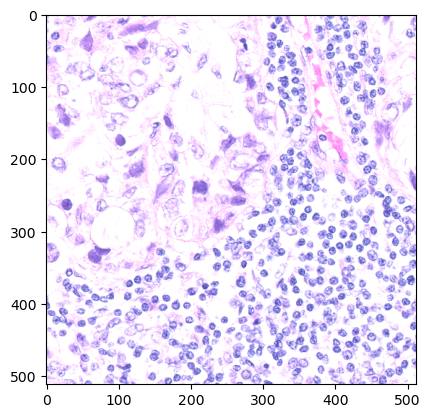

In [9]:
# Change color intensity
# Run this code multiple times!!!
cjitter = transforms.ColorJitter(brightness=.6)
col_transformed_tumour_img = cjitter(tumour_image)
plt.imshow(col_transformed_tumour_img.permute(1,2,0))

Now that we have introduced the dataset and learned about some preprocessing steps, we can move on to the next step, which is building our deep network.

## Deep Network

In order to train and test our deep network for classifying histopathology images, we need to follow a few simple steps. First, we need to load the datasets that we will use to train and evaluate our model. Second, we need to initialize the network, which involves defining the architecture of the CNN. Third, we need to train the network using the training dataset, which involves optimizing the weights of the network based on the input images and their corresponding labels. Finally, we need to test the network using the test datasets, which involves evaluating the performance of the model on the unseen data.

In this notebook, we have provided all the necessary functions to perform these steps. The functions are provided to you in as needed in each section. Specifically, we have provided functions to:

1. Load the training and test datasets
2. Define the architecture of the CNN
3. Train the model using the training dataset
4. Test the model using the test datasets

## Load the Training Dataset

In deep learning, we typically train the model on large datasets that cannot be processed at once due to memory limitations. Instead, we divide the dataset into smaller subsets or batches, which are processed sequentially during training. The "batch size" refers to the number of samples in each batch that the model processes before updating its weights. Increasing the batch size can speed up the training process, but it also requires more memory.

In [10]:
def LoadDatset(path, test = True):
    
    '''
    The purpose of this function is to load the dataset based on the specified path. 
    
    If we want to evaluate the data, we can set the 'test' flag to True, which will load the test dataset without
    additional augmentations.
    '''
    
    if not test:
        transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                        transforms.ColorJitter(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        
    else:
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        
    data_ = datasets.ImageFolder(root=path, transform=transform)
    data_ = data.DataLoader(data_, batch_size=batch_size, shuffle=True,  num_workers=4)
    
    print(f'Dataset contains {len(data_.dataset)} sample patches.')

    return data_

In [11]:
batch_size = 32

train_data = LoadDatset('Images/Train')

Dataset contains 450 sample patches.


## Define the Architecture of the CNN and Train the Model

You can easily customize the model and experiment with different configurations to optimize the performance. The parameters that can be modified for optimization purposes are called hyperparameters. Some of these hyperparameters for a CNN model are batch size, learning rate, and epochs.

* Learning rate: The learning rate is a hyperparameter that determines how much the weights of the model are adjusted with each iteration during training. It controls the step size that the optimizer takes while searching for the optimal set of weights. A high learning rate can cause the model to overshoot the optimal weights and fail to converge, while a low learning rate can cause slow convergence or getting stuck in a suboptimal solution.

* Epochs: An epoch refers to a complete iteration over the entire training dataset. During each epoch, the model processes all the samples in the training dataset and updates its weights based on the errors made during prediction. Training for multiple epochs allows the model to see the data multiple times, which can help it learn the underlying patterns and generalize better. However, training for too many epochs can lead to overfitting.

We encourage you to modify the code and try out different configurations/hyperparameters to see how the model performs under different conditions.

In [13]:
def InitiateNetwork(baseline):
    
    '''
    The purpose of this function is to initiate the network.
    '''
    
    network = getattr(torchvision.models, baseline)
    network = network(pretrained=True)
    network.fc = nn.Linear(network.fc.in_features, 2)
    
    return network.to(device)

In [14]:
def TrainNetwork(data_):
    
    '''
    The purpose of this function is to:
    
        1. load a dataset
        2. initialize a network
        3. optimize its weights based on the training dataset
    '''
    
    network   = InitiateNetwork(baseline)
    optimizer = torch.optim.Adam(network.fc.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        network.train()
        loss_value = 0
        
        for (data, label) in tqdm(data_, desc='Training',
                                  dynamic_ncols=True, leave=True, position=0):
            
            data, label = data.to(device), label.to(device)
            
            logit = network(data)
            prob  = torch.softmax(logit, dim=1)
            
            loss = criterion(logit.type(torch.float), label.type(torch.long))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_value += loss.item() * label.shape[0]
            
        print(f'Epoch: {epoch}: training loss is {loss_value / len(data_.dataset):0.4f}')
        
        torch.save({'network': network.state_dict()},
                   f"Checkpoint/network.pth")


In [15]:
epochs        = 5
device        = 'cuda' if torch.cuda.is_available() else 'cpu'
baseline      = 'resnet18'
learning_rate = 1e-4

After setting the hyperparameters, we can start training our network with the following command:

**Note:** It will take several minutes (up to about an hour) to train our neural network depending on the computing resources! On a MacBook with M2 processing unit and 24GB memory, it took about 12 minutes and on an instance of Google colab notebook, it took about an hour to run the below code.

In [18]:
TrainNetwork(train_data)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:33<00:00,  6.25s/it]

Epoch: 0: training loss is 0.8816


FileNotFoundError: [Errno 2] No such file or directory: 'Checkpoint/network.pth'

During training, the loss of the model is printed for each epoch. It is important to analyze the trend of the training loss and discuss it with your team. What does the trend of the training loss show?

## Evaluation

After training the model, we need to evaluate its performance on the test data to see how well it generalizes to unseen data. This step is crucial because it allows us to assess the true performance of the model and detect any issues. We evaluate the model by computing various metrics such as accuracy and confusion matrix.

In this notebook, we have provided a sample of both tumour and normal images from the first test dataset to help you visualize the dataset and the performance of the model.

<img src="Images/Test_1/Normal/101376_29696.png" width="256">

The above image is labeled as normal by a pathologist. Our goal is to determine whether the trained network can correctly predict the label of this image. To do this, we have provided the following code. After running the code, take a look at the predicted label and compare it to the true label. Discuss the results with your teammates and see if there are any insights or improvements that can be made.

In [13]:
def LoadNetwork(baseline):
    
    '''
    The purpose of this function is to load the trained network to evaluate the test datasets.
    '''
    
    network = InitiateNetwork(baseline)
    state   = torch.load('Checkpoint/network.pth', map_location=device) 
    
    network.load_state_dict(state["network"], strict=True)
    
    return network

In [14]:
def PredictPatch(path_to_patch):
    
    '''
    The purpose of this function is to predict the label of a given patch.
    '''
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    
    patch = Image.open(path_to_patch)
    patch = transform(patch).unsqueeze(0).to(device)
    
    network = LoadNetwork(baseline)
    network.eval()
    
    logit = network(patch)
    pred  = torch.argmax(logit, dim=1).cpu().numpy()
    
    if pred[0] == 0:
        print('Normal')
    else:
        print('Tumor')

In [16]:
path = 'Images/Test_1/Normal/101376_29696.png'
PredictPatch(path)

Normal


Repeat the same process with the following image, labelled as a tumour by a pathologist, by running the provided code and analyzing the predicted label. Compare the predicted label to the true label and discuss the results with your teammates.

<img src="Images/Test_1/Tumor/81920_57344.png" width="256">


In [17]:
path = 'Images/Test_1/Tumor/81920_57344.png'
PredictPatch(path)

Tumor


Now that you have inspected a sample from each class, it's time to evaluate the performance of the model on the first test set. Run the provided code and analyze the results. Discuss the performance with your teammates and see if you are satisfied with it.

Keep in mind that the hyperparameters we set earlier, such as the batch size, learning rate, and number of epochs, have a significant impact on the performance of the model. If you are not happy with the results on the test set, feel free to experiment with different hyperparameters and evaluate the performance again.

In [18]:
def TestNetwork(data_):
    
    '''
    The purpose of this function is to:
    
        1. load a dataset
        2. load the trained network
        3. evaluate the trained network on the test datasets
    '''
    
    network = LoadNetwork(baseline)
    network.eval()
    
    gt, preds = [], []
    
    for (data, label) in tqdm(data_, desc='Evaluating',
                              dynamic_ncols=True, leave=True, position=0):
        
        data, label = data.to(device), label.to(device)
        
        logit = network(data)
        prob  = torch.softmax(logit, dim=1)
        pred  = torch.argmax(prob, dim=1).cpu().numpy().tolist()
        
        gt.extend(label.cpu().numpy().tolist())
        preds.extend(pred)
        
    accuracy = accuracy_score(gt, preds)
    conf_mat = confusion_matrix(gt, preds).T
    
    print(f'Testing accuracy is {accuracy*100:0.2f}%')
    print(f'Confusion Matrix is \n{conf_mat}')

In [19]:
test_data = LoadDatset('Images/Test_1', test=True)
TestNetwork(test_data)

Dataset contains 50 sample patches.


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.36s/it]

Testing accuracy is 90.00%
Confusion Matrix is 
[[22  2]
 [ 3 23]]


How do you interpret the accuracy on test data? Are there other metrics that you can use to measure the model's performance? How these other metrics can be useful to evaluate the performance?

What's the confusion matrix? What can you learn from it?

## Homework

As a homework assignment, we would like you to evaluate your network on the second test dataset using the same steps we used for the first test dataset. 

1. First, visualize one sample image from each class in the 'Images/Test_2' folder to get an idea of the data. 
2. Then, evaluate the performance of the network on the complete dataset.

After evaluating the performance, compare the results with the performance on the first test dataset. Are there any noticeable differences in the performance? If so, why do you think this is the case? Discuss the results and see if there are any improvements or adjustments that can be made to the model.

In [20]:
## In this cell, load a sample image from the 'Normal' class and display the prediction made by the network.


In [21]:
## In this cell, load a sample image from the 'Tumor' class and display the prediction made by the network.


In [22]:
## In this cell, evaluate the model on the entire samples of the second test dataset 
## and provide an overall measure of the model's performance on the data.


**Bonus:** For bonus marks, find the hyperparameters that lead to the best performance of the model on our data.